# Stochastic Invasion of Variants of Concern

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd

In [2]:
# =============================================================================
# Class for solving ODEs
# =============================================================================
class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        if isinstance(self.u0, float):
            self.numeqs=1
        else:
            self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    

class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew

In [3]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP_extinct:
    # Set offspring distribution for the process - this defines the process
    def __init__(self, offspring):
        self.offspring = offspring
    
    # Set lifetimes for particles of each type
    def set_lifespans(self, omega):
        self.omega = omega
    
    # Set a vector of immigration rates
    def set_immigration(self, eta):    
        self.eta = eta
    
    # Build ODEs for the probability of extinction of a process that begins with a single particle of each type, 
    # excluding immigration. The final equation includes immigration and describes the full process starting with a
    # vector of n0 particles of each type and immigration at rate eta. 
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
        method = methodclass(set_odes)
        method.set_ic(u0=ics)
        R, t = method.solver(time_points=t)
#         R = sp.integrate.odeint(set_odes, ics, time).T
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if Full:
            return R
        else:
            if isinstance(n0, float):
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0)
            else:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0[i])
            rho = r*Qprod
            sol = np.stack((Qprod, rho), axis=0)
            return sol
    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]
    
    def set_Omega(self, Omega):
        self.Omega=Omega
        return None
    
    def set_mean_odes(self, u, t):
        try:
            Omega = self.Omega
        except NotImplementedError:
            print("Need to set Omega first!")
        P = self.offspring
        eta = self.eta
        omega = self.omega
        if isinstance(u, float):
            self.meaneqs=1
            deriv = np.zeros(self.meaneqs)
            deriv[0] = u*Omega(t) + eta(t)
            return deriv
        else:
            self.meaneqs = len(u)
            meaneqs = self.meaneqs
            deriv = np.zeros(meaneqs)
            deriv = u@Omega(t) + eta(t)
            return deriv
        
    def solve_mean_odes(self, set_mean_odes, t, ics, methodclass=RungeKutta4):
        method = methodclass(set_mean_odes)
        method.set_ic(u0=ics)
        M, t = method.solver(time_points=t)
#         M = sp.integrate.odeint(set_mean_odes, ics, t).T
        return M
        

In [461]:
# Parameters to change 

ntypes = 8
nexposed = int(ntypes/2)

# Disease Parameters

Reff_vec = np.array((1.22, 1.54, 1.79, 2.52, 2.94)) # R without immunity for wildtype with roadmap changes
rtrans_variant = 1.5 # Relative transmissability of SA variant compared to wildtype
gamma = 0.4 # Recovery Rate
sigma = 0.3 # Progression rate from exposed to infectious

# Vaccine parameters for transmission reduction 

sus_uk = 1-0.9 # Susceptibility of unvaccinated B.1.351 recovereds against wildtype
sus_sa = 1-0.4 # Susceptibility of unvaccinated wildtype recovereds against B.1.351
vac_uk = 1-0.7 # Reduction in transmission of UK variant due to vaccine
vac_sa = 1-0.6 # Reduction in transmission of SA variant due to vaccine
# vaccine_vec = np.array((1., az_vac_sa, pfi_vac_sa, new_vac_sa))

#k = -1 #1/10 # Dispersion Endo et al.

Tmax = 200 
num = 200
time = np.linspace(0, Tmax, num=num)

# Reduced transmissability for each type based on infection/vaccine immunity
# const_vec = np.array((1., sus_sa, az_vac_sa, az_vac_sa*sus_sa, pfi_vac_sa, pfi_vac_sa*sus_sa, new_vac_sa, new_vac_sa*sus_sa))
const_vec = np.array((1., sus_sa, vac_sa, np.min((vac_sa, sus_sa))))



# Vector of proportions of susceptibles for each type:


p_az = 0.32 # % vaccinated with AstraZeneca
p_pf = 0.17 # % vaccinated with Pfizer
p_vac = p_az + p_pf
# p_new = 0 # % vaccinated with putative new vaccine (currently 0) 
p_no_vac = 1- p_az - p_pf #- p_new # % unvaccinated

p_rec = 0.245 # % recovered from previous strains
p_sus = 1-p_rec # % never infected with any coronavirus


prop_vec = np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_vac, p_rec*p_vac))



# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days

cluster_im = 1
if not cluster_im:
    discount_imports = 0
    im =1/5.
    im_vec = np.zeros(ntypes)
    im_vec[:nexposed] = im*prop_vec*const_vec # Rate of importation for unvaccinated exposed cases of variants with no previous infection history
else:
    discount_imports = 1
    ntypes+=1
    cluster_size = 2
    alpha = 0.3
    cluster_rate = 1/5
    im_vec = np.zeros(ntypes)
    im_vec[0] = cluster_rate
   


In [462]:
# np.mean(np.random.negative_binomial(cluster_size, alpha, 1000))


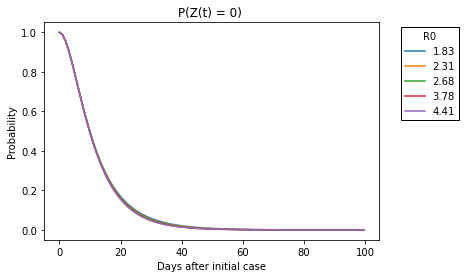

In [463]:
# Solve ODEs 

rho_mat = np.zeros((len(Reff_vec), len(time)))
q_mat = np.zeros_like(rho_mat)
R_vec = np.zeros_like(Reff_vec)
showplot_rho = 100
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
#     beta_vec = beta_SA * prop_vec
    RV = Reff*rtrans_variant

    
    omega_vec = sigma * np.ones(ntypes) 
    if cluster_im:
        omega_vec = np.append(cluster_rate, omega_vec)
    
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        
    def omega(t): # Return vector of lifetimes for each state
        return omega_vec

#     beta_vec = beta_SA*np.ones(nexposed)
#     for i in range(0, len(vaccine_vec)):
#         beta_vec[2*i:2*i+2]*= vaccine_vec[i]
    
    def P(u, t): # Offspring distribution

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_SA) + gamma)
#         sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*(1+(1/k)*(1-u[:nexposed]))**(-k))
        
        if cluster_im:
            omega0 = np.sum(prop_vec*const_vec*cluster_size)
            pvec[0] = np.sum((prop_vec*const_vec)*(1+((cluster_size)/alpha)*(1-u[1:(nexposed+1)]))**(-alpha))
            sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*u[1:(nexposed + 1)])
        else:
            sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*u[:nexposed])
        for nex in range(0, nexposed):
            if cluster_im:
                
                pvec[nex+1] = u[nex+nexposed+1] 
                pvec[nex+nexposed+1] =  u[nex+nexposed+1] * sum_gen_funcs + (gamma/omega)
            else:
                
                pvec[nex] = u[nex+nexposed] 
                pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs + (gamma/omega)
        
        
        return pvec            
            
            
    def eta(t):
        return im_vec.astype(float)
    ics = np.zeros(ntypes+1)
    ics[-1] = 1.
    ics[0] = 1.
    n0vec = np.zeros(ntypes)
#     n0vec[0] = 1


    offspring = P
    outbreak = MTBP_extinct(offspring)
    outbreak.set_lifespans(omega)
    outbreak.set_immigration(eta)
    rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0vec, Full = True) # Solve ODEs for probabilities of extinction/zero
    q_mat [r, :] = rho[0, :]
    rho_mat[r, :] = rho[-1, :] # Take 0th row for qs, -1th row for rs

    plt.plot(time[:showplot_rho], rho_mat[r, :showplot_rho], label = str(np.round(RV, 2)))

plt.title("P(Z(t) = 0) " )
plt.xlabel("Days after initial case")
plt.ylabel("Probability")
# plt.savefig("./pnocases_im=" + str(im) + "_beta=" + str(Reff_vec[0]*gamma*rtrans_variant)+ "_n0=0.pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
# plt.plot(time[:showplot_rho], np.exp(-1/5*time[:showplot_rho]), color = 'black')

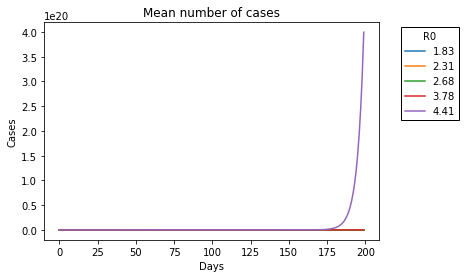

In [464]:
# Mean over time 
# Reff_vec = np.linspace(1.22, 2.94, num=20)
mean_cond = np.zeros((len(Reff_vec), len(time)))

if discount_imports:
    mean_arr = np.zeros((len(Reff_vec), ntypes-1, len(time)))
else:
    mean_arr = np.zeros((len(Reff_vec), ntypes, len(time)))
    
mean = np.zeros_like(mean_cond)
showplot = -1
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant
    
    def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
            Omat = np.zeros((ntypes, ntypes))
            omega_vec = sigma * np.ones(ntypes)       
            if cluster_im:
                omega_vec[0] = np.sum(const_vec*prop_vec*cluster_size)
                for nex in range(0, nexposed):
                    Omat[0, nex+1] = const_vec[nex]*prop_vec[nex]*cluster_size
                    omega_vec[nex + nexposed+1] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                    Omat[nex+1, nex+nexposed+1] = omega_vec[nex+1]
                    Omat[nex+nexposed+1, 1:(nexposed+1)] = const_vec*prop_vec*beta_SA 
                    Omat[nex+nexposed+1, nex+nexposed+1] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)
            else:
                for nex in range(0, nexposed):
                    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                    Omat[nex, nex+nexposed] = omega_vec[nex]
                    Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
                    Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)

            return Omat
    outbreak.set_Omega(Omega)
    n0s = np.zeros(ntypes)
#     n0s[0] = 1.
    if discount_imports:
        Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s)[1:, :]
    else:
        Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s)
    mean_arr[r, :, :] = Mvec
#     mean_cond[r, :] = np.sum(Mvec, axis=0)

#     mean_cond[r, :] = np.sum(Mvec/(1-rho_mat[r, :] + np.finfo(float).eps), axis=0)
    
    mean[r, :] = np.sum(Mvec, axis=0)
    plt.plot(time[:showplot], mean[r, :showplot], label = str(np.round(RV, 2)))
plt.title("Mean number of cases" )
plt.xlabel("Days")
plt.ylabel("Cases")
# plt.savefig("./meancases_im=" + str(im) + "_R0=" + str(RV)+ "_n0=0.pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")



In [465]:
# Variance  - for highest R0 (or single value to be chosen)
# Build a vector C from matrix G as in Garden of BPs
# Reff_vec = np.linspace(1.22, 2.94, num=20)
var_vec = np.zeros((len(Reff_vec), len(time)))
lamb_vec = np.zeros(len(Reff_vec)) # Vector of growth rates for each R0

for r in range(0, len(Reff_vec)):
    Reff = Reff_vec[r]
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant
    
    def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
            Omat = np.zeros((ntypes, ntypes))
            omega_vec = sigma * np.ones(ntypes)      
            if cluster_im:
                omega_vec[0] = np.sum(const_vec*prop_vec*cluster_size)
                for nex in range(0, nexposed):
                    Omat[0, nex+1] = const_vec[nex]*prop_vec[nex]*cluster_size
                    omega_vec[nex + nexposed+1] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                    Omat[nex+1, nex+nexposed+1] = omega_vec[nex+1]
                    Omat[nex+nexposed+1, 1:(nexposed+1)] = const_vec*prop_vec*beta_SA
                    Omat[nex+nexposed+1, nex+nexposed+1] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)
            else:
                for nex in range(0, nexposed):
                    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                    Omat[nex, nex+nexposed] = omega_vec[nex]
                    Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA
                    Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)
            return Omat

    # Diagonalise Omega and find H as in Garden of BPs paper

    eigvls, orth = nla.eig(Omega(0))
    eigvls = np.real_if_close(eigvls)
    orth = orth
    print(nla.cond(Omega(0)))
    lamb = np.max(eigvls)
    diagmat = np.real_if_close(np.diag(eigvls))
   
    if np.isreal(eigvls).all():
        for ev in range(0, len(orth)):
            orth[:, ev] = np.real_if_close(orth[:, ev])
            if not np.isreal(orth[:, ev]).all():
                orth[:, ev+1] = np.imag(orth[:, ev])
                orth[:, ev] = np.real(orth[:, ev])
               
    print("All eigenvectors of orth are real: " + str(np.isreal(orth.all())))
   
    orth = np.real_if_close(orth)
#     orth = np.round(orth, 14)
    orth_inv = nla.inv(orth)
    orth_c = orth.copy().conjugate()
    orthc_inv = nla.inv(orth_c)
    H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
    # H[6*ntypes*ntypes:(8)*ntypes*ntypes, 6*ntypes*ntypes:(8)*ntypes*ntypes] = 0
    Hinv = nla.inv(H) # np.kron(orth_inv, np.kron(orth_c, orth_c))
   
   

    # Hinv = nla.inv(H)

    def H_mat(t, beta): # Hessian of the Offspring Distribution

        Hmat = np.zeros((ntypes, ntypes, ntypes))
        omega_vec = sigma * np.ones(ntypes)
       
       
        if cluster_im:
            for i in range(1, nexposed+1):
                Hmat[0, i, i] = (const_vec[i-1]*prop_vec[i-1] * (cluster_size**2) * (alpha+1)/alpha)#/np.sum(const_vec*prop_vec*cluster_size)

            for level in range(1, nexposed+1):
                omega_vec[level + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
                for i in range(1, nexposed+1):

        #             Hmat[level + nexposed, i, i] =  (const_vec[i]*beta_SA*prop_vec[i])/(omega_vec[level+nexposed])
                    Hmat[level + nexposed, level+nexposed, i] = (beta * const_vec[i-1]*prop_vec[i-1])/(omega_vec[level+nexposed-1])
                    Hmat[level + nexposed, i, level+nexposed] = (beta * const_vec[i-1]*prop_vec[i-1])/(omega_vec[level+nexposed-1])

        else:
            for level in range(0, nexposed):
                omega_vec[level + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
                for i in range(0, nexposed):

        #             Hmat[level + nexposed, i, i] =  (const_vec[i]*beta_SA*prop_vec[i])/(omega_vec[level+nexposed])
                    Hmat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
                    Hmat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])

        return Hmat

    def P_vecs(t, beta): # Essentially the same as Omega matrix - matrix of partial derivatives - columns should be partial derivatives of each P_i(s)

        Omat = np.zeros((ntypes, ntypes))
        omega_vec = sigma * np.ones(ntypes)
        if cluster_im:
            omega_vec[0] = np.sum(const_vec*prop_vec*cluster_size)
            for nex in range(0, nexposed):
                Omat[nex+1, 0] = const_vec[nex]*prop_vec[nex]*cluster_size
                omega_vec[nex + nexposed+1] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                Omat[nex+1, nex+nexposed+1] = omega_vec[nex+1]
                Omat[nex+nexposed+1, 1:(nexposed+1)] = const_vec*prop_vec*beta_SA
                Omat[nex+nexposed+1, nex+nexposed+1] = np.sum(const_vec * beta_SA * prop_vec)

        else:
            for nex in range(0, nexposed):
                omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                Omat[nex, nex+nexposed] = omega_vec[nex]
                Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA
                Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

        return Omat


    # Compose Gmat

    Gmat = np.zeros((ntypes, ntypes, ntypes))
    C = np.zeros(ntypes**3)
    omega_vec = sigma * np.ones(ntypes)
    if cluster_im:
        omega_vec[0] = np.sum(const_vec*prop_vec*cluster_size)
        for nex in range(0, nexposed):
            omega_vec[nex + nexposed + 1] = np.sum(const_vec*prop_vec*beta_SA) + gamma
    else:
        for nex in range(0, nexposed):
            omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
    Pmat = P_vecs(0, beta_SA)
#     for l in range(0, ntypes):
#         Pmat[l, :] /= omega_vec
    
    for l in range(0, ntypes):

        Gmat[l, :, :] = H_mat(0, beta_SA)[l, :, :] + np.diag(Pmat[:, l]) - np.outer(Pmat[:, l], Pmat[:, l])
        unitvec = np.zeros(ntypes)
        unitvec[l] = 1
        Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(Pmat[:, l], Pmat[:, l]) - np.outer(unitvec, Pmat[:, l]) - np.outer(Pmat[:, l], unitvec)
        Gmat[l, :, :] *= omega_vec[l]
        C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator

    Amat = np.kron(orthc_inv, orthc_inv)
    vec_w = np.zeros(ntypes**3)
    Amat_inv = nla.inv(Amat)

    HinvC = nla.solve(H, C)

    def Deltamat(t, immigration, eigvls, l):
        Delta = np.zeros(ntypes**2)
        eigs = eigvls.copy()
        for j in range(0, ntypes):
            for n in range(0, ntypes):
                Delta[j*ntypes + n] =  immigration[l]*(1-np.exp((eigs[j] + eigs[n])*t))/(-eigs[j] - eigs[n])
        Deltamat = np.diag(Delta)
        return Deltamat


    def Deltamat_im(t, immigration, eigvls):
        Delta = np.zeros(ntypes**3)
        eigs = eigvls.copy()
        for l in range(0, ntypes):
            for j in range(0, ntypes):
                for n in range(0, ntypes):
                    Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
    #                 Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))

        Deltamat = np.diag(Delta)
        return Deltamat


    # Build both components for variance with immigration from eq. 21 and final eq. on p.213
    def var(t):
#         Amat = np.kron(nla.inv(orth_c.copy()), nla.inv(orth_c.copy()))
        vec_w = np.zeros(ntypes**3)
#         Amat_inv = nla.inv(Amat.copy())
        vecvar =  H @ Deltamat_im(t, im_vec, eigvls) @ HinvC

        for i in range(0, ntypes):
            unitvec = np.zeros(ntypes)
            unitvec[i] = 1.
            unit_outer_prod = np.outer(unitvec, unitvec).flatten('F') # Stack columns for 'vec' operator
            vec_wi =  Amat @ ( Deltamat(t, im_vec, eigvls, i)) @ Amat_inv @unit_outer_prod
            vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi
            vecvar[i*ntypes*ntypes:(i+1)*ntypes*ntypes] *=im_vec[i]



    #     vecvar =  H @ Deltamat_im(t, im_vec, eigvls) @ HinvC
        var_im = np.reshape(vecvar, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
        w = np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)

        var_im += w
        return var_im # np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)




    # varmat = np.sum(var(30), axis=0) # Sum variance for all different types into total variance matrix
   
    T=0
    for Time in tqdm(time):
        if cluster_im:
            if discount_imports:
                var_vec[r, T] = np.sum(var(Time)[:, :, :])
            else:
                var_vec[r, T] = np.sum(var(Time))
        else:
            var_vec[r, T] = np.sum(var(Time))
        T+=1

  4%|▍         | 8/200 [00:00<00:02, 72.99it/s]

71.957058117395
All eigenvectors of orth are real: True


  4%|▍         | 9/200 [00:00<00:02, 89.55it/s]

33.53282403699657
All eigenvectors of orth are real: True


  4%|▍         | 9/200 [00:00<00:02, 88.54it/s]

26.078504689533073
All eigenvectors of orth are real: True


  4%|▍         | 9/200 [00:00<00:02, 86.25it/s]

19.769433238729917
All eigenvectors of orth are real: True


  4%|▍         | 9/200 [00:00<00:02, 89.29it/s]

19.086227862759255
All eigenvectors of orth are real: True


100%|██████████| 200/200 [00:02<00:00, 91.51it/s]


In [425]:
var_vec

array([[0.00000000e+00, 1.10793908e+00, 3.04487408e+00, 4.97048193e+00,
        6.66473454e+00, 8.14776408e+00, 9.49181473e+00, 1.07635848e+01,
        1.20136672e+01, 1.32785231e+01, 1.45844272e+01, 1.59508367e+01,
        1.73928395e+01, 1.89228359e+01, 2.05516662e+01, 2.22893562e+01,
        2.41456110e+01, 2.61301443e+01, 2.82529030e+01, 3.05242268e+01,
        3.29549684e+01, 3.55565883e+01, 3.83412379e+01, 4.13218333e+01,
        4.45121273e+01, 4.79267796e+01, 5.15814289e+01, 5.54927669e+01,
        5.96786156e+01, 6.41580087e+01, 6.89512777e+01, 7.40801425e+01,
        7.95678089e+01, 8.54390709e+01, 9.17204209e+01, 9.84401665e+01,
        1.05628555e+02, 1.13317908e+02, 1.21542761e+02, 1.30340018e+02,
        1.39749112e+02, 1.49812177e+02, 1.60574236e+02, 1.72083396e+02,
        1.84391062e+02, 1.97552157e+02, 2.11625369e+02, 2.26673403e+02,
        2.42763258e+02, 2.59966524e+02, 2.78359687e+02, 2.98024473e+02,
        3.19048200e+02, 3.41524163e+02, 3.65552040e+02, 3.912383

In [448]:
tstars = np.zeros(len(Reff_vec))
mean_stars = np.zeros((len(Reff_vec), ntypes-1))
tstar_idxs = np.zeros(len(Reff_vec))
Istar = 100
for r, Reff in enumerate(Reff_vec):
    if mean[r, -1]>=Istar:
        tstar_idx  = np.min(np.where(mean[r, :] >= Istar)[0])
        tstar_idxs[r] = tstar_idx
        tstar = time[tstar_idx]
        mean_stars[r, :] = mean_arr[r, :, tstar_idx]
    else:
        tstar = np.nan
    tstars[r] = tstar
tstar_idxs = tstar_idxs.astype(int)
tstars

array([151.75879397,  51.25628141,  33.16582915,  22.11055276,
        17.08542714])

<ipython-input-452-f3eac03ab889>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-452-f3eac03ab889>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-452-f3eac03ab889>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-452-f3eac03ab889>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-452-f3eac03ab889>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-452-f3eac03ab889>:16: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(var_vec[r, :]), label = str(RV))
<ipython-input-452-f3eac03ab889>:16: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(var_vec[r, :]), label = str(RV))
<ipython-inp

Text(0, 0.5, 'Days')

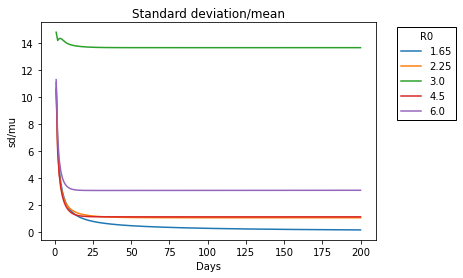

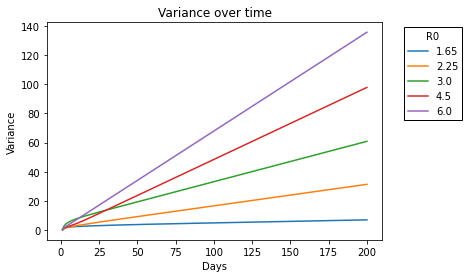

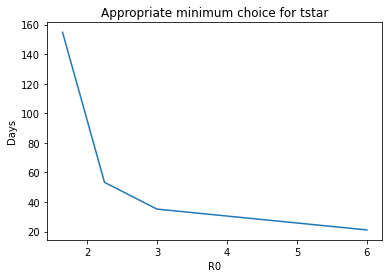

In [452]:
sig_vec= np.sqrt(var_vec)
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
#     sig_over_mean = (sig_vec[r, :]/(mean_cond[r, :] ))
    plt.plot(time, sig_over_mean , label = str(RV))
plt.title("Standard deviation/mean")
plt.ylabel("sd/mu")
plt.xlabel("Days")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
# plt.savefig("./sd_over_mean_plot.pdf")

plt.figure()
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    plt.plot(time, np.log(var_vec[r, :]), label = str(RV))
plt.title("Variance over time")
plt.ylabel("Variance")
plt.xlabel("Days")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")

# Plot T^star for each R0

tol = 1e-3
Tstars = np.zeros(len(Reff_vec))
Tstar_idx = np.zeros(len(Reff_vec)).astype(int)
for r in range(0, len(Reff_vec)):
    if r != 12:
        sig_over_mean = (sig_vec[r, :])/(mean[r, :])
        diff = np.gradient(sig_over_mean)
        Tstar_idx[r] = (np.min(np.where(np.abs(diff[1:])<=tol)[0]))
        Tstars[r] = time[Tstar_idx[r]]
plt.figure()
plt.plot(Reff_vec*rtrans_variant, Tstars)
plt.title("Appropriate minimum choice for tstar")
plt.xlabel("R0")
plt.ylabel("Days")
# plt.savefig("./tstarchoice.pdf")

In [453]:
Tstar_idx

array([154,  53,  35,  28,  21])

<ipython-input-454-bbf2d0500f6d>:36: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color, label = "sd/mean")
<ipython-input-454-bbf2d0500f6d>:40: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
<ipython-input-454-bbf2d0500f6d>:40: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
<ipython-input-454-bbf2d0500f6d>:40: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
<ipython-input-454-bbf2d0500f6d>:40: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)


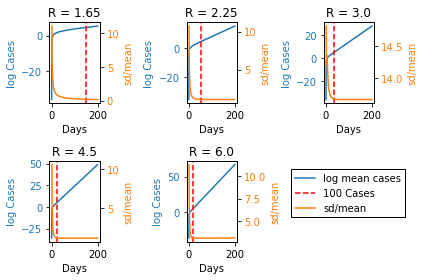

In [454]:
np.hstack((Tstars, tstars))
time[Tstar_idx]
threshold = 100
Istars_min = np.zeros_like(Tstar_idx)
tst_idx = np.zeros_like(Tstar_idx)
for r in range(0, len(Reff_vec)):
    Istars_min[r] = mean[r, Tstar_idx[r]]
    tst_idx[r] = np.min(np.where(mean[r, :]>=threshold))

showplot = int(len(time))

fig, axs = plt.subplots(2, 3)
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    if r<=2:
        b = 0
    else:
        b=1    
    color = 'tab:blue'
    if r ==0:
        
        axs[b, r%3].plot(time[:showplot], np.log(mean[r, :showplot] + np.finfo(float).eps) , color = color, label = "log mean cases")
    else:
        axs[b, r%3].plot(time[:showplot], np.log(mean[r, :showplot] + np.finfo(float).eps) , color = color)
        axs[b, r%3].axvline(time[tst_idx[r]], color = 'r', linestyle = '--')
    axs[b, r%3].tick_params(axis='y', labelcolor=color)
    
    axs[b, r%3].set_ylabel("log Cases", color = color)
    axs[b, r%3].set_ylabel("log Cases", color = color)
    axs[b, r%3].set_xlabel("Days")
    axs[b, r%3].set_title("R = " + str(RV))
    axs[-1, -1].set_visible(False)
    color= 'tab:orange'
    ax1 = axs[b, r%3].twinx()
    if r ==0:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color, label = "sd/mean")
        axs[b, r%3].axvline(time[tst_idx[r]], color = 'r', linestyle = '--', label = str(threshold) + " Cases")

    else:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel("sd/mean", color = color)
    
    
    
bottom_right_ax = axs[-1][-1] 
bottom_right_ax.clear()  
bottom_right_ax.set_axis_off()
fig.legend(loc='lower right', bbox_to_anchor=(0.95, 0.2),framealpha=1., edgecolor='black', fancybox=False)

fig.tight_layout()

DescribeResult(nobs=10000, minmax=(0.16399437787215376, 714.1619737450145), mean=21.75165139229553, variance=2371.2235904835034, skewness=5.820453760216234, kurtosis=47.429526901622275)

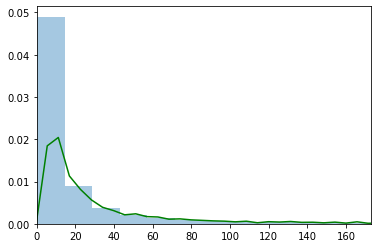

In [460]:
idx = 4

t_idx = Tstar_idx[idx]
tval = Tstar_idx[idx]


varnew = var_vec[idx, tval]
Istar = Istars_min[idx]


sd = np.sqrt(varnew)

nu = np.log(Istar)




wald = np.random.wald(time[tval], (nu**2/((sd/(Istar))**2)), size=10000)
df = pd.Series(wald, name = "Days")

# sns.distplot(df, stat = "density")
# sns.kdeplot(df, color = "orange") 
sns.distplot(wald, kde_kws={"color": "g"})
plt.xlim(0, np.quantile(wald, 1-0.025)+20)



# normal = np.random.normal(nu, nu**2/((sd/(Istar))**2), size=10000)
# dfnu = pd.Series(normal, name = "Days")
# sns.distplot(dfnu, kde_kws={"color": "g"})


# plt.savefig("./time_distplot_R0=" + str(RV) + ".pdf")
# plt.savefig("./time_distplot_alternative_R0=" + str(RV) + ".pdf")
sp.stats.describe(wald)



array([89, 49, 38, 25, 22])